In [1]:
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import cKDTree
root_dir = os.path.abspath(os.curdir)
pred_dir_subs = os.path.dirname(root_dir)+"/SubmissionPredictions/"
pred_dir_coms = os.path.dirname(root_dir)+"/CommentPredictions/"
#Create directory to save experiment results
results_dir = os.path.dirname(root_dir)+"/Results/"
os.makedirs(results_dir, exist_ok=True)
#Create directory to save experiment figures
figs_dir = os.path.dirname(root_dir)+"/Figures/"
os.makedirs(figs_dir, exist_ok=True)
%matplotlib inline

In [2]:
def computeDelta(collection,pred_dir):
    print(collection)
    for year in range(2006,2008):
        output = results_dir+collection+'sDelta-'+str(year)+'.csv'
        with open(output,'a') as out:
            print(year)
            out.write("Username,Delta\n")
            df = pd.read_csv(pred_dir+str(year)+'.csv')
            x = 1
            y = 1
            YearOfFocus = year
            df['myDate'] = pd.to_datetime(df['Time'])
            for userName, df1 in df.groupby("Author"):
                df1 = df1.sort_values(by='myDate')
                df1['year'] = pd.DatetimeIndex(df1['myDate']).year
                df1 = df1.loc[df1['year'] == YearOfFocus]
                if df1.size:
                    #print(df1)
                    myCounts = df1.groupby(['Subreddit']).count().reset_index()
                    #print("Total number of subreddits:",myCounts)
                    NumberOfSubreddits = len(myCounts)
                    #print("Count of subreddits:")
                    #print(NumberOfSubreddits)
                    df1 = df1.groupby(['Subreddit','Label']).size().reset_index()
                    HT = df1.loc[df1['Label'] == 'highly_toxic']
                    ST = df1.loc[df1['Label'] == 'slightly_toxic']
                    Toxic = HT.append(ST, ignore_index=True)
                    #Toxic = ST
                    #print("Toxic subreddits:")
                    #print(Toxic)
                    #First we have to group them for both HT and ST
                    Toxic = Toxic.groupby(['Subreddit']).count().reset_index()
                    #print(Toxic)
                    #print("Total number of toxic subreddits:", len(Toxic))
                    finalCounts= myCounts.loc[myCounts['Subreddit'].isin(Toxic['Subreddit'].tolist())]
                    #Since they are of the same order, we can transform them to lists then divide
                    #print(finalCounts)
                    myTxc= Toxic['Label'].tolist()
                    myCnts = finalCounts['ID'].tolist()
                    finalCounts['proportions'] = [x/y for x, y in zip(myTxc, myCnts)]

                    if finalCounts.proportions.size:
                        # print(userName,end=',')
                        #Now with the proportions we can calculate delta
                        theMax = finalCounts['proportions'].loc[finalCounts['proportions'].idxmax()]
                        theMin = finalCounts['proportions'].loc[finalCounts['proportions'].idxmin()]
                        myDelta = theMax - theMin

                        out.write(userName+','+str(myDelta)+'\n')
                else:          
                    y = 1
            else:
                x = 0
            del df 
            gc.collect()

def combineDeltaUsers(collection):
    #year1 = [x for x in range(2005,2020)]
    #year2 = [x for x in range(2006,2021)]
    year1 = [2006]
    year2 = [2007]
    for Y1,Y2 in zip(year1,year2):
        print(Y1,Y2)
        data = []
        file1 = results_dir+collection+'sDelta-'+str(Y1)+'.csv'
        file2 = results_dir+collection+'sDelta-'+str(Y2)+'.csv'
        df1 = pd.read_csv(file1) #,header=None,names=['Username','Delta']
        df1['Year'] = Y1
        df2 = pd.read_csv(file2)
        df2['Year'] = Y2
        #df.columns = ['Username', year]
        data.append(df1)
        data.append(df2)
        dfs = [df.set_index(['Username']) for df in data]
        result = pd.concat(dfs, axis=1).reset_index()

        result.columns = ['index','Delta1','Year1','Delta2','Year2']
        result = result.dropna(subset = ['Year1','Year2'])
        print(result.head())
        output = results_dir+collection+'sDeltasUsers-'+str(Y1)+'-'+str(Y2)+'.csv'
        result.to_csv(output,index=False)
        del df1
        del df2
        del data
        del result
        gc.collect()


def data_coord2view_coord(p, resolution, pmin, pmax):
    dp = pmax - pmin
    dv = (p - pmin) / dp * resolution
    return dv

def kNN2DDens(xv, yv, resolution, neighbours, dim=2):
    """
    """
    # Create the tree
    tree = cKDTree(np.array([xv, yv]).T)
    # Find the closest nnmax-1 neighbors (first entry is the point itself)
    grid = np.mgrid[0:resolution, 0:resolution].T.reshape(resolution**2, dim)
    dists = tree.query(grid, neighbours)
    # Inverse of the sum of distances to each grid point.
    inv_sum_dists = 1. / dists[0].sum(1)

    # Reshape
    im = inv_sum_dists.reshape(resolution, resolution)
    return im

def plotDelta(collection):
    # year1 = [x for x in range(2006,2020)]
    # year2 = [x for x in range(2007,2021)]
    year1 = [2006]
    year2 = [2007]
    for Y1, Y2 in zip(year1,year2):
        print(Y1,Y2)
        file =results_dir+collection+'sDeltasUsers-'+str(Y1)+'-'+str(Y2)+'.csv'
        DF1 = pd.read_csv(file)
        DF1 = DF1[(DF1[['Delta1','Delta2']] != 0).all(axis=1)]

        xs = DF1['Delta1'].to_numpy(dtype='float')                                 
        ys = DF1['Delta2'].to_numpy(dtype='float')

        resolution = 250

        extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]
        xv = data_coord2view_coord(xs, resolution, extent[0], extent[1])
        yv = data_coord2view_coord(ys, resolution, extent[2], extent[3])
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        for ax, neighbours in zip(axes.flatten(), [0, 16, 32, 63]):

            if neighbours == 0:
                ax.plot(xs, ys, 'k.', markersize=5)
                ax.set_aspect('equal')
                ax.set_title("Scatter Plot")
                ax.set_xlabel('Delta '+str(Y1))
                ax.set_ylabel('Delta '+str(Y2))
            else:

                im = kNN2DDens(xv, yv, resolution, neighbours)

                ax.imshow(im, origin='lower', extent=extent, cmap=cm.jet)
                ax.set_title("Smoothing over %d neighbours" % neighbours)
                ax.set_xlim(extent[0], extent[1])
                ax.set_ylim(extent[2], extent[3])
                ax.set_xlabel('Delta '+str(Y1))
                ax.set_ylabel('Delta '+str(Y2))


        output = figs_dir+collection+'-'+str(Y1)+'-'+str(Y2)+'.jpg'
        plt.savefig(output, dpi=300, bbox_inches='tight')


Submission
2006
2007
2006 2007
               index    Delta1   Year1    Delta2   Year2
0             9jack9  0.000000  2006.0  0.086111  2007.0
1            AGivant  0.000000  2006.0  0.000000  2007.0
2              Aerik  0.000000  2006.0  0.123528  2007.0
3  AnarchoCapitalist  0.000000  2006.0  0.000000  2007.0
4               Arve  0.158635  2006.0  0.121198  2007.0
2006 2007
Comment
2006
2007
2006 2007
    index    Delta1   Year1    Delta2   Year2
0     0sn  0.000000  2006.0  0.000000  2007.0
4    9917  0.000000  2006.0  0.000000  2007.0
5  9jack9  0.015126  2006.0  0.490909  2007.0
6    9ner  0.119169  2006.0  0.163527  2007.0
8   Aerik  0.000000  2006.0  0.498071  2007.0
2006 2007


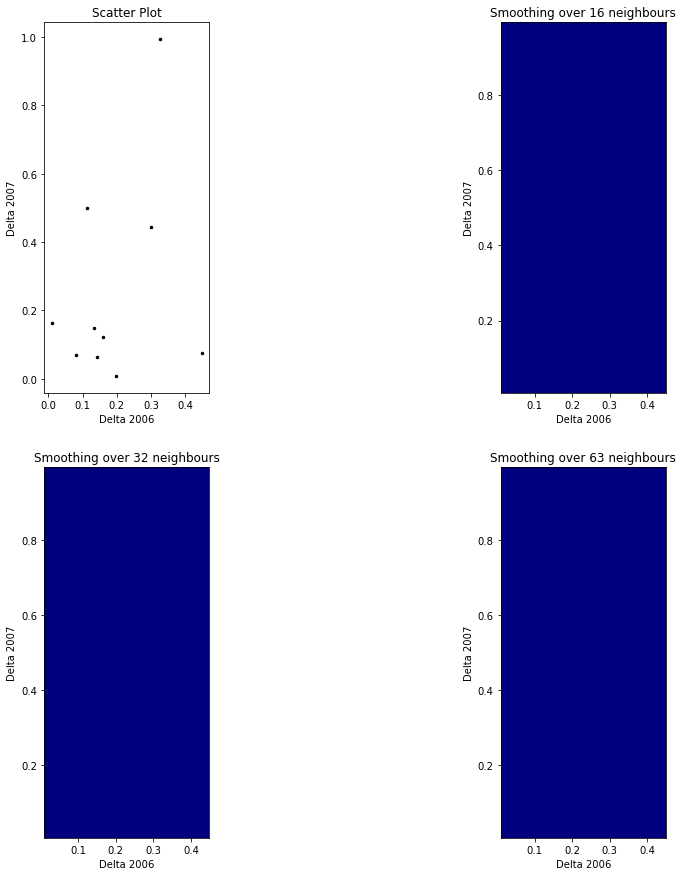

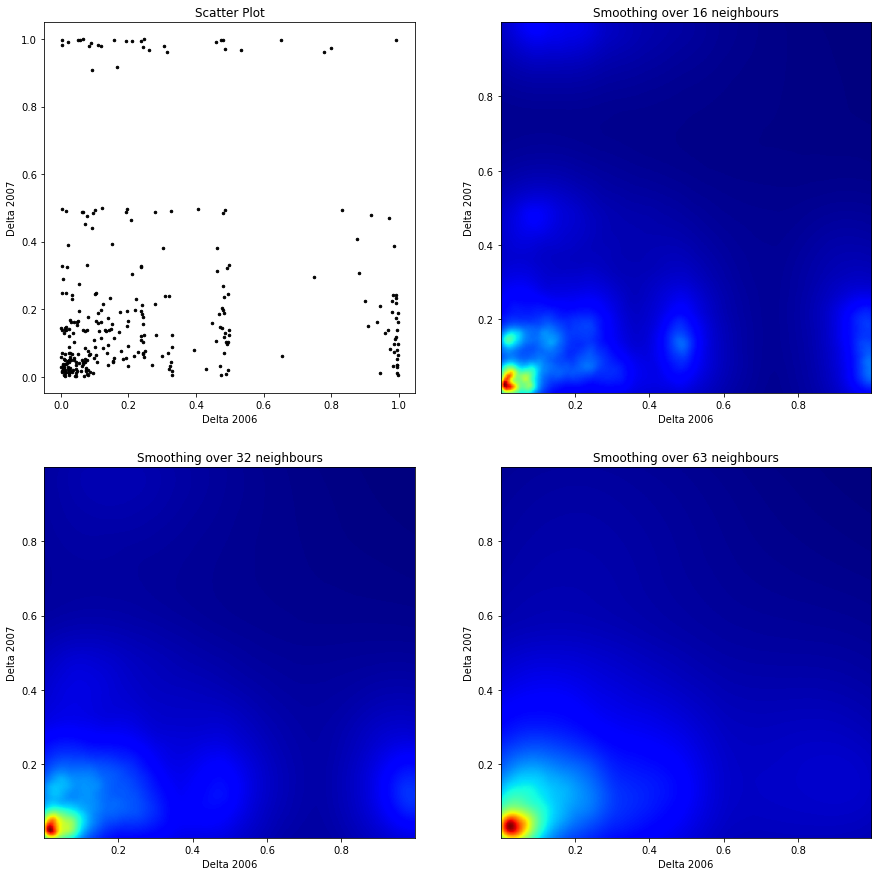

In [3]:
computeDelta("Submission",pred_dir_subs)
combineDeltaUsers("Submission")
plotDelta("Submission")
computeDelta("Comment",pred_dir_coms)
combineDeltaUsers("Comment")
plotDelta("Comment")